## 1. Importation des bibliothèques et chargement des données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("✅ Bibliothèques importées avec succès!")

✅ Bibliothèques importées avec succès!


In [33]:
# Chargement des données
stations = pd.read_csv('../data/stations.csv')
journeys = pd.read_csv('../data/journeys.csv')
A = np.load('../data/A_npy.npy')  # Matrice de connectivité
mu_z = np.load('../data/mu_z.npy')  # Variables latentes pré-calculées

print(f"Stations: {stations.shape[0]} stations")
print(f"Trajets: {journeys.shape[0]:,} trajets")
print(f"Matrice A: {A.shape}")
print(f"Variables latentes mu_z: {mu_z.shape}")

Stations: 773 stations
Trajets: 1,542,844 trajets
Matrice A: (779, 779)
Variables latentes mu_z: (779, 17)


## 2. Exploration des données

In [34]:
# Aperçu des stations
print("=== STATIONS ===")
display(stations.head(10))
print(f"\n Nombre de stations: {len(stations)}")
print(f" Capacité moyenne: {stations['Capacity'].mean():.1f} vélos")
print(f" Capacité totale: {stations['Capacity'].sum()} vélos")

=== STATIONS ===


Station ID  Capacity   Latitude  Longitude  \
0           1        19  51.529163  -0.109970   
1           2        37  51.499606  -0.197574   
2           3        32  51.521283  -0.084605   
3           4        23  51.530059  -0.120973   
4           5        27  51.493130  -0.156876   
5           6        18  51.518117  -0.144228   
6           7        16  51.534300  -0.168074   
7           8        18  51.528341  -0.170134   
8           9        19  51.507385  -0.096440   
9          10        18  51.505974  -0.092754   

                           Station Name  
0            River Street , Clerkenwell  
1        Phillimore Gardens, Kensington  
2  Christopher Street, Liverpool Street  
3       St. Chad's Street, King's Cross  
4         Sedding Street, Sloane Square  
5        Broadcasting House, Marylebone  
6     Charlbert Street, St. John's Wood  
7           Lodge Road, St. John's Wood  
8              New Globe Walk, Bankside  
9                 Park Street, Bankside


 Nombre de stations: 773
 Capacité moyenne: 26.7 vélos
 Capacité totale: 20659 vélos


In [35]:
# Aperçu des trajets
print("=== TRAJETS ===")
display(journeys.head())
print(f"\n Durée moyenne: {journeys['Journey Duration'].mean()/60:.1f} minutes")
print(f" Durée médiane: {journeys['Journey Duration'].median()/60:.1f} minutes")

=== TRAJETS ===


Journey Duration  Journey ID  End Date  End Month  End Year  End Hour  \
0            2040.0         953        19          9        17        18   
1            1800.0       12581        19          9        17        15   
2            1140.0        1159        15          9        17        17   
3             420.0        2375        14          9        17        12   
4            1200.0       14659        13          9        17        19   

   End Minute  End Station ID  Start Date  Start Month  Start Year  \
0           0             478          19            9          17   
1          21             122          19            9          17   
2           1             639          15            9          17   
3          16             755          14            9          17   
4          33             605          13            9          17   

   Start Hour  Start Minute  Start Station ID  
0          17            26               251  
1          14            51               550  
2          16            42               212  
3          12             9               163  
4          19            13                36


 Durée moyenne: 22.1 minutes
 Durée médiane: 14.1 minutes


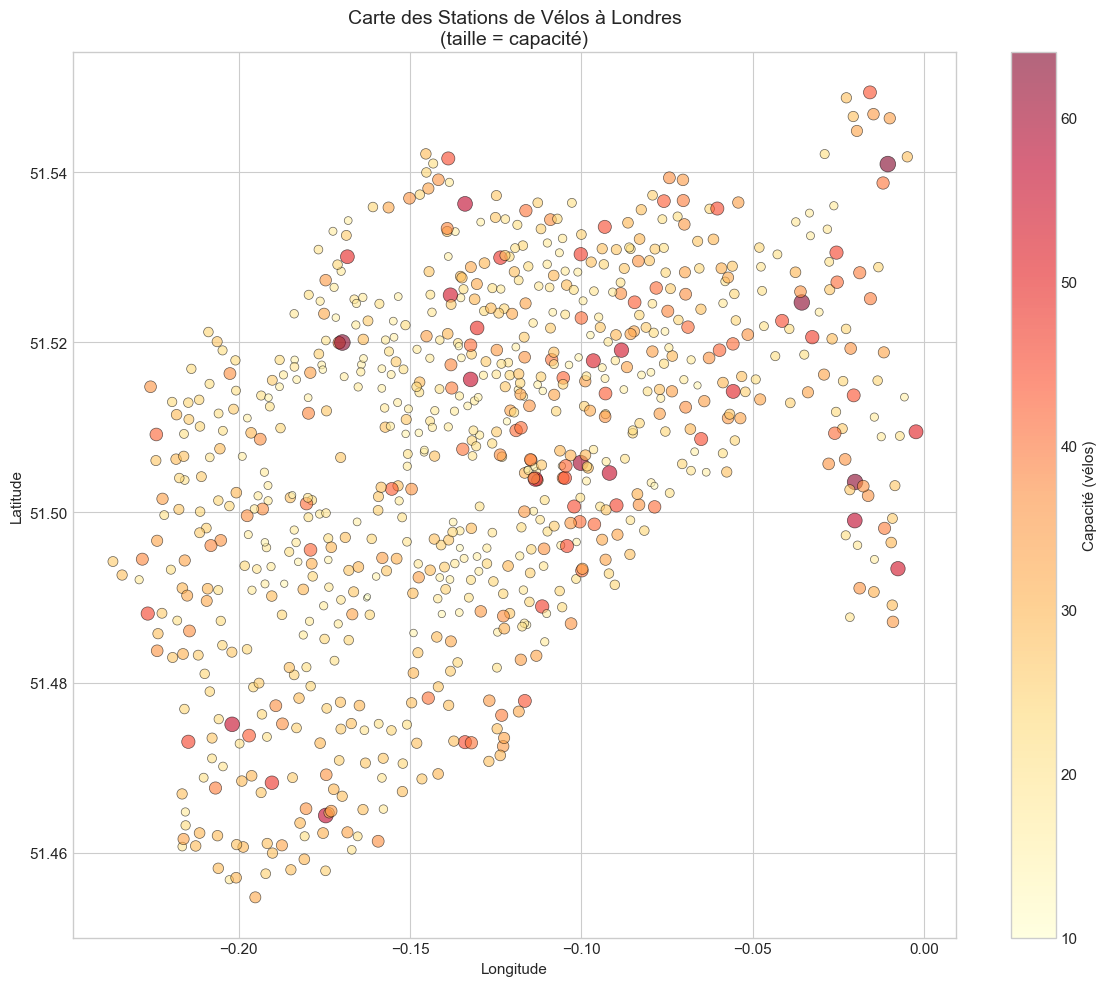

In [37]:
# Visualisation géographique des stations
fig, ax = plt.subplots(figsize=(12, 10))

scatter = ax.scatter(
    stations['Longitude'], 
    stations['Latitude'],
    c=stations['Capacity'],
    cmap='YlOrRd',
    s=stations['Capacity']*2,
    alpha=0.6,
    edgecolors='black',
    linewidths=0.5
)

plt.colorbar(scatter, label='Capacité (vélos)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Carte des Stations de Vélos à Londres\n(taille = capacité)', fontsize=14)
plt.tight_layout()
plt.savefig('../results/carte_stations.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Construction et Analyse de la Matrice de Connectivité

In [38]:
# Analyse de la matrice de connectivité existante
print("=== MATRICE DE CONNECTIVITÉ A ===")
print(f"Dimension: {A.shape}")
print(f"Type: {A.dtype}")
print(f"Valeurs: min={A.min()}, max={A.max()}, moyenne={A.mean():.2f}")
print(f"Somme totale des trajets: {A.sum():,}")

# Vérification de la symétrie
est_symetrique = np.allclose(A, A.T)
print(f"\n Matrice symétrique: {est_symetrique}")

# Vérification des auto-boucles
auto_boucles = np.trace(A)
print(f"Auto-boucles (diagonale): {auto_boucles}")

=== MATRICE DE CONNECTIVITÉ A ===
Dimension: (779, 779)
Type: int64
Valeurs: min=0, max=990, moyenne=2.42
Somme totale des trajets: 1,468,701

 Matrice symétrique: False
Auto-boucles (diagonale): 0


In [39]:
# Création de la matrice binaire d'adjacence
A_binaire = (A > 0).astype(int)

print("=== MATRICE BINAIRE D'ADJACENCE ===")
print(f"Nombre de connexions (arêtes): {A_binaire.sum() // 2:,}")
print(f"Densité du graphe: {A_binaire.sum() / (A.shape[0] * (A.shape[0]-1)):.4f}")

# Degré des nœuds
degres = A_binaire.sum(axis=1)
print(f"\nDegré moyen: {degres.mean():.1f}")
print(f"Degré max: {degres.max()}")
print(f"Degré min: {degres.min()}")

=== MATRICE BINAIRE D'ADJACENCE ===
Nombre de connexions (arêtes): 112,035
Densité du graphe: 0.3697

Degré moyen: 287.6
Degré max: 602
Degré min: 52


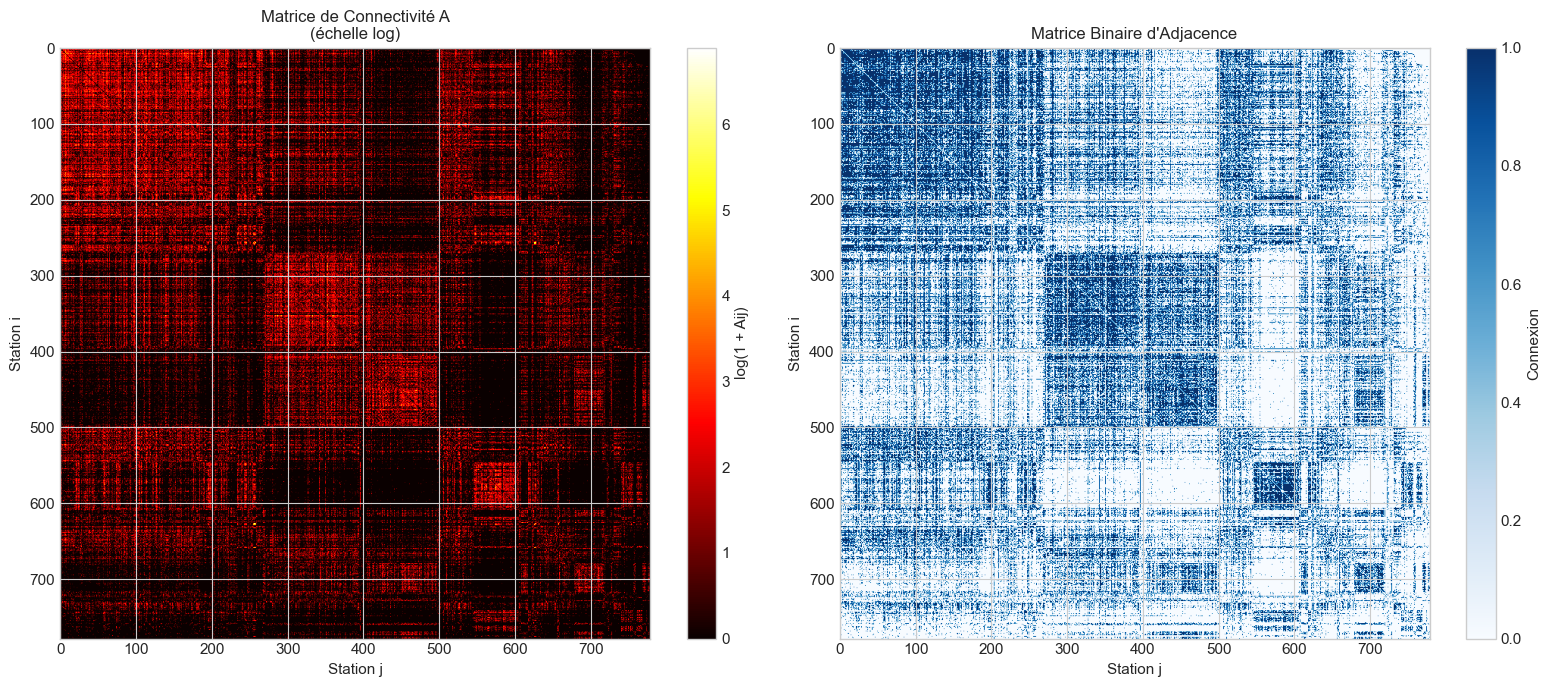

In [40]:
# Visualisation de la matrice de connectivité
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Matrice pondérée (log pour meilleure visualisation)
im1 = axes[0].imshow(np.log1p(A), cmap='hot', aspect='auto')
axes[0].set_title('Matrice de Connectivité A\n(échelle log)', fontsize=12)
axes[0].set_xlabel('Station j')
axes[0].set_ylabel('Station i')
plt.colorbar(im1, ax=axes[0], label='log(1 + Aij)')

# Matrice binaire
im2 = axes[1].imshow(A_binaire, cmap='Blues', aspect='auto')
axes[1].set_title('Matrice Binaire d\'Adjacence', fontsize=12)
axes[1].set_xlabel('Station j')
axes[1].set_ylabel('Station i')
plt.colorbar(im2, ax=axes[1], label='Connexion')

plt.tight_layout()
plt.savefig('../results/matrices_connectivite.png', dpi=150, bbox_inches='tight')
plt.show()

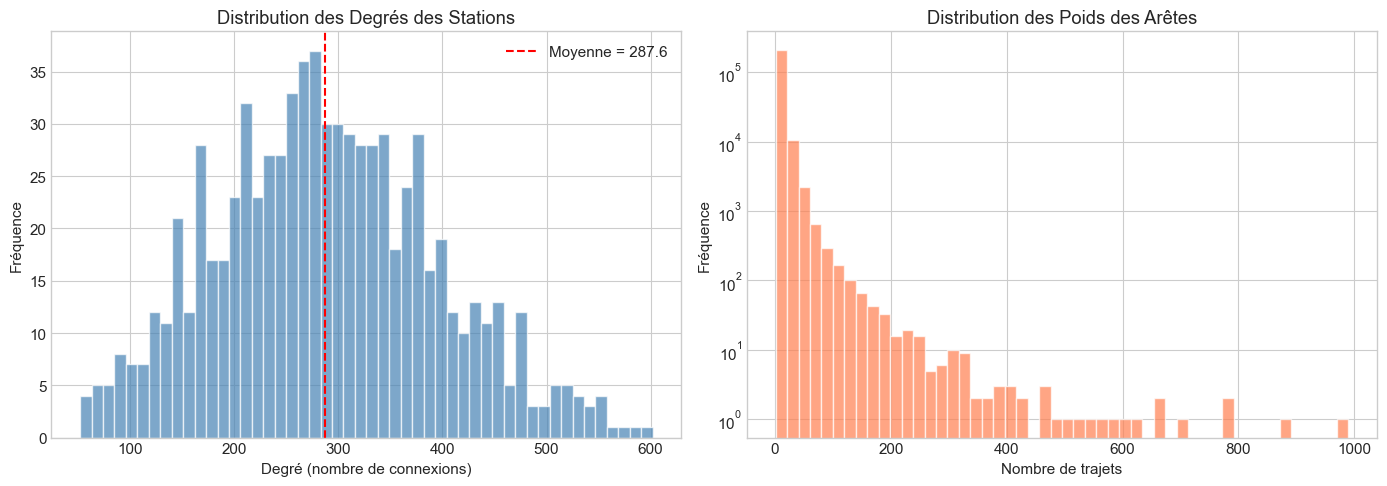

In [41]:
# Distribution des degrés
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme des degrés
axes[0].hist(degres, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
axes[0].axvline(degres.mean(), color='red', linestyle='--', label=f'Moyenne = {degres.mean():.1f}')
axes[0].set_xlabel('Degré (nombre de connexions)')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des Degrés des Stations')
axes[0].legend()

# Distribution des poids
poids = A[A > 0].flatten()
axes[1].hist(poids, bins=50, color='coral', edgecolor='white', alpha=0.7)
axes[1].set_xlabel('Nombre de trajets')
axes[1].set_ylabel('Fréquence')
axes[1].set_title('Distribution des Poids des Arêtes')
axes[1].set_yscale('log')

plt.tight_layout()
plt.savefig('../results/distribution_degres_poids.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Réduction de Dimension avec ACP Probabiliste (PPCA)

In [10]:
# Les variables latentes mu_z sont déjà pré-calculées
# Mais nous allons aussi faire notre propre PPCA pour comparaison

print("=== VARIABLES LATENTES PRÉ-CALCULÉES (mu_z) ===")
print(f"Shape: {mu_z.shape}")
print(f"Chaque station est représentée par un vecteur de dimension {mu_z.shape[1]}")

=== VARIABLES LATENTES PRÉ-CALCULÉES (mu_z) ===
Shape: (779, 17)
Chaque station est représentée par un vecteur de dimension 17


In [11]:
# ACP classique pour comparaison et analyse
# Normalisation des données (chaque ligne de A représente le profil d'une station)
scaler = StandardScaler()
A_scaled = scaler.fit_transform(A)

# ACP
pca = PCA()
pca.fit(A_scaled)

# Variance expliquée
variance_cumulee = np.cumsum(pca.explained_variance_ratio_)

print("=== ANALYSE EN COMPOSANTES PRINCIPALES ===")
print(f"Variance expliquée par les 5 premières composantes: {variance_cumulee[4]:.2%}")
print(f"Variance expliquée par les 10 premières composantes: {variance_cumulee[9]:.2%}")
print(f"Variance expliquée par les 17 premières composantes: {variance_cumulee[16]:.2%}")

=== ANALYSE EN COMPOSANTES PRINCIPALES ===
Variance expliquée par les 5 premières composantes: 34.24%
Variance expliquée par les 10 premières composantes: 44.58%
Variance expliquée par les 17 premières composantes: 52.48%


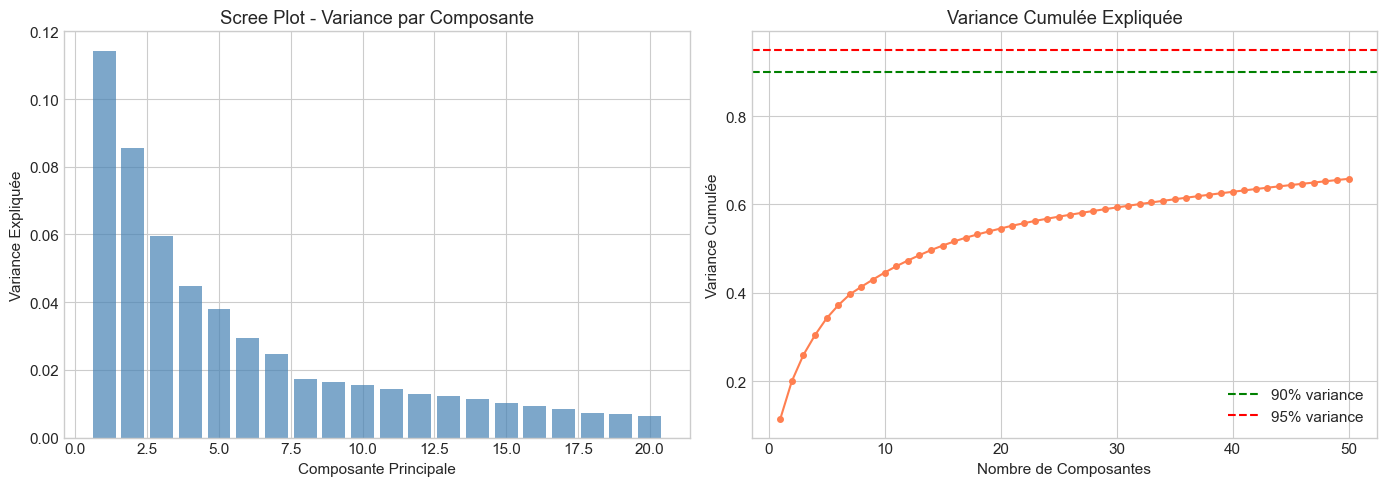

In [12]:
# Visualisation de la variance expliquée
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, 21), pca.explained_variance_ratio_[:20], color='steelblue', alpha=0.7)
axes[0].set_xlabel('Composante Principale')
axes[0].set_ylabel('Variance Expliquée')
axes[0].set_title('Scree Plot - Variance par Composante')

# Variance cumulée
axes[1].plot(range(1, 51), variance_cumulee[:50], 'o-', color='coral', markersize=4)
axes[1].axhline(y=0.90, color='green', linestyle='--', label='90% variance')
axes[1].axhline(y=0.95, color='red', linestyle='--', label='95% variance')
axes[1].set_xlabel('Nombre de Composantes')
axes[1].set_ylabel('Variance Cumulée')
axes[1].set_title('Variance Cumulée Expliquée')
axes[1].legend()

plt.tight_layout()
plt.savefig('../results/acp_variance.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# Projection dans l'espace latent (utilisons mu_z qui est déjà calculé)
# Ou calculons notre propre projection avec d=17 composantes
d = 17  # Dimension latente
pca_d = PCA(n_components=d)
Z = pca_d.fit_transform(A_scaled)

print(f"Projection dans R^{d}")
print(f"Variance expliquée: {pca_d.explained_variance_ratio_.sum():.2%}")
print(f"\nComparaison avec mu_z pré-calculé:")
print(f"  - Notre Z: shape {Z.shape}")
print(f"  - mu_z fourni: shape {mu_z.shape}")

Projection dans R^17
Variance expliquée: 52.48%

Comparaison avec mu_z pré-calculé:
  - Notre Z: shape (779, 17)
  - mu_z fourni: shape (779, 17)


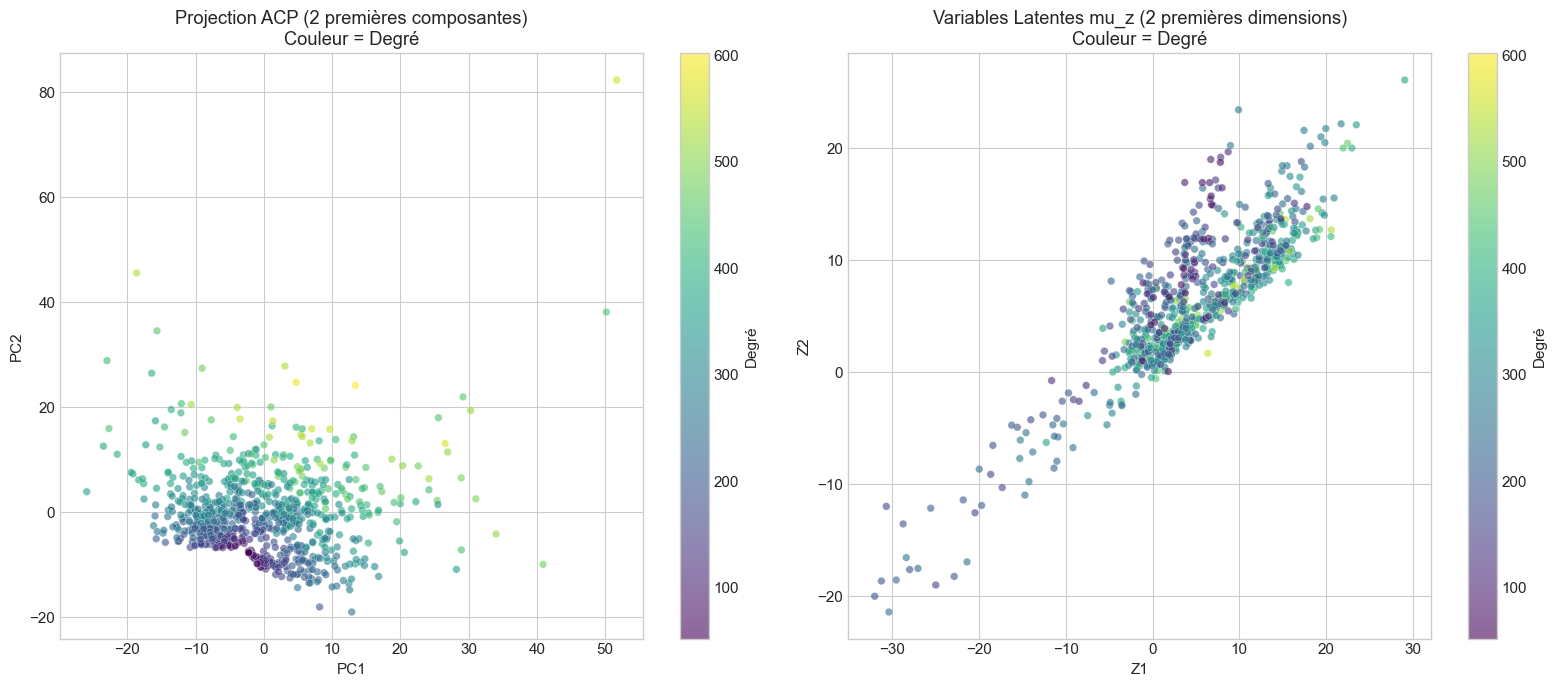

In [14]:
# Visualisation 2D de l'espace latent
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Notre projection
scatter1 = axes[0].scatter(Z[:, 0], Z[:, 1], c=degres[:len(Z)], cmap='viridis', 
                          s=30, alpha=0.6, edgecolors='white', linewidths=0.3)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('Projection ACP (2 premières composantes)\nCouleur = Degré')
plt.colorbar(scatter1, ax=axes[0], label='Degré')

# mu_z pré-calculé
scatter2 = axes[1].scatter(mu_z[:, 0], mu_z[:, 1], c=degres[:len(mu_z)], cmap='viridis',
                          s=30, alpha=0.6, edgecolors='white', linewidths=0.3)
axes[1].set_xlabel('Z1')
axes[1].set_ylabel('Z2')
axes[1].set_title('Variables Latentes mu_z (2 premières dimensions)\nCouleur = Degré')
plt.colorbar(scatter2, ax=axes[1], label='Degré')

plt.tight_layout()
plt.savefig('../results/espace_latent_2d.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Clustering: K-Means et Gaussian Mixture Model

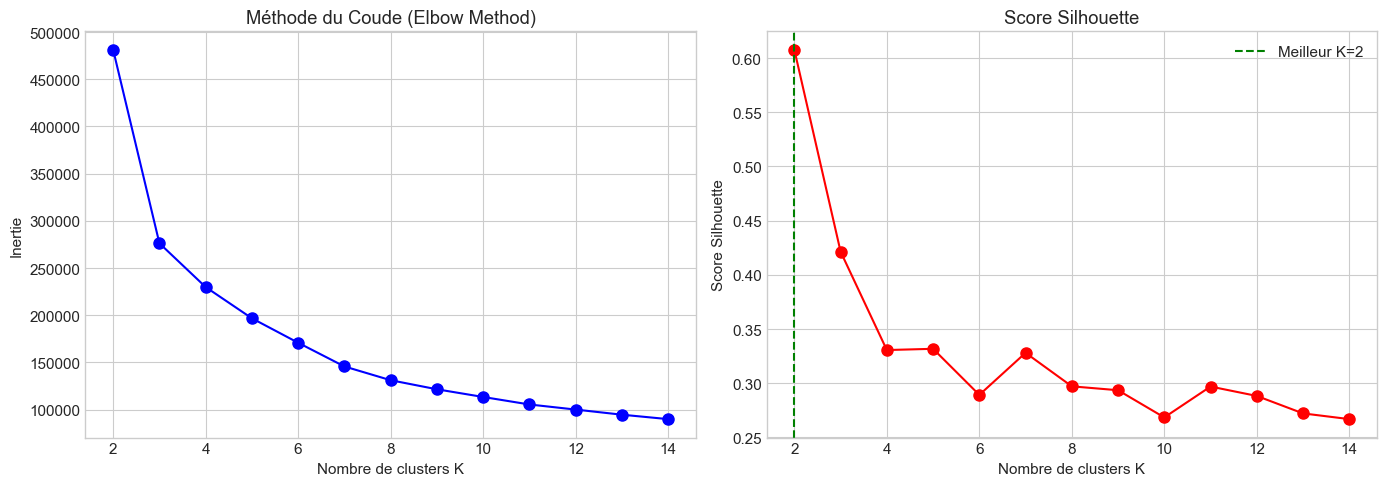


✅ Meilleur K selon silhouette: 2


In [15]:
# Détermination du nombre optimal de clusters avec la méthode du coude et silhouette
K_range = range(2, 15)
inertias = []
silhouettes = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(mu_z)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(mu_z, labels))

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Méthode du coude
axes[0].plot(K_range, inertias, 'bo-', markersize=8)
axes[0].set_xlabel('Nombre de clusters K')
axes[0].set_ylabel('Inertie')
axes[0].set_title('Méthode du Coude (Elbow Method)')

# Score silhouette
axes[1].plot(K_range, silhouettes, 'ro-', markersize=8)
axes[1].set_xlabel('Nombre de clusters K')
axes[1].set_ylabel('Score Silhouette')
axes[1].set_title('Score Silhouette')
best_k = K_range[np.argmax(silhouettes)]
axes[1].axvline(x=best_k, color='green', linestyle='--', label=f'Meilleur K={best_k}')
axes[1].legend()

plt.tight_layout()
plt.savefig('../results/selection_k.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Meilleur K selon silhouette: {best_k}")

In [16]:
# K-Means avec K optimal
K = 5  # On choisit K=5 pour une bonne interprétabilité

kmeans = KMeans(n_clusters=K, random_state=42, n_init=20)
labels_kmeans = kmeans.fit_predict(mu_z)

print("=== K-MEANS CLUSTERING ===")
print(f"Nombre de clusters: {K}")
print(f"Score silhouette: {silhouette_score(mu_z, labels_kmeans):.4f}")
print(f"\nRépartition des stations par cluster:")
for i in range(K):
    print(f"  Cluster {i}: {(labels_kmeans == i).sum()} stations")

=== K-MEANS CLUSTERING ===
Nombre de clusters: 5
Score silhouette: 0.3312

Répartition des stations par cluster:
  Cluster 0: 182 stations
  Cluster 1: 127 stations
  Cluster 2: 41 stations
  Cluster 3: 331 stations
  Cluster 4: 98 stations


In [17]:
# Gaussian Mixture Model
gmm = GaussianMixture(n_components=K, covariance_type='full', random_state=42, n_init=10)
labels_gmm = gmm.fit_predict(mu_z)
proba_gmm = gmm.predict_proba(mu_z)

print("=== GAUSSIAN MIXTURE MODEL ===")
print(f"Nombre de composantes: {K}")
print(f"Score silhouette: {silhouette_score(mu_z, labels_gmm):.4f}")
print(f"BIC: {gmm.bic(mu_z):.2f}")
print(f"AIC: {gmm.aic(mu_z):.2f}")
print(f"\nRépartition des stations par cluster:")
for i in range(K):
    print(f"  Cluster {i}: {(labels_gmm == i).sum()} stations")

# Accord entre K-means et GMM
ari = adjusted_rand_score(labels_kmeans, labels_gmm)
print(f"\nAccord K-means/GMM (ARI): {ari:.4f}")

=== GAUSSIAN MIXTURE MODEL ===
Nombre de composantes: 5
Score silhouette: 0.0553
BIC: 28363.36
AIC: 24385.42

Répartition des stations par cluster:
  Cluster 0: 105 stations
  Cluster 1: 129 stations
  Cluster 2: 157 stations
  Cluster 3: 173 stations
  Cluster 4: 215 stations

Accord K-means/GMM (ARI): 0.2634


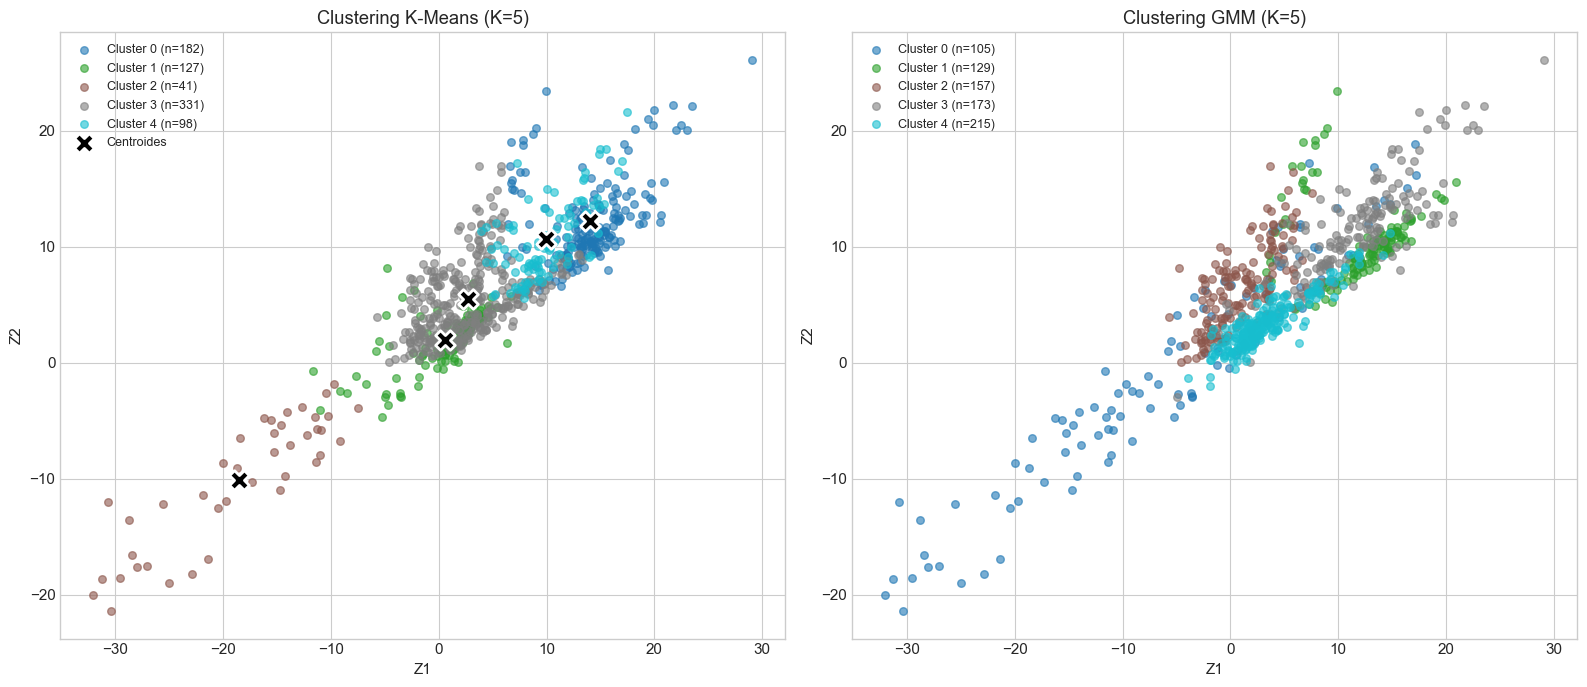

In [18]:
# Visualisation des clusters dans l'espace 2D
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

colors = plt.cm.tab10(np.linspace(0, 1, K))

# K-means
for i in range(K):
    mask = labels_kmeans == i
    axes[0].scatter(mu_z[mask, 0], mu_z[mask, 1], c=[colors[i]], 
                   label=f'Cluster {i} (n={mask.sum()})', s=30, alpha=0.6)
axes[0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
               c='black', marker='X', s=200, edgecolors='white', linewidths=2, label='Centroides')
axes[0].set_xlabel('Z1')
axes[0].set_ylabel('Z2')
axes[0].set_title(f'Clustering K-Means (K={K})')
axes[0].legend(loc='best', fontsize=9)

# GMM
for i in range(K):
    mask = labels_gmm == i
    axes[1].scatter(mu_z[mask, 0], mu_z[mask, 1], c=[colors[i]], 
                   label=f'Cluster {i} (n={mask.sum()})', s=30, alpha=0.6)
axes[1].set_xlabel('Z1')
axes[1].set_ylabel('Z2')
axes[1].set_title(f'Clustering GMM (K={K})')
axes[1].legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('../results/clusters_2d.png', dpi=150, bbox_inches='tight')
plt.show()

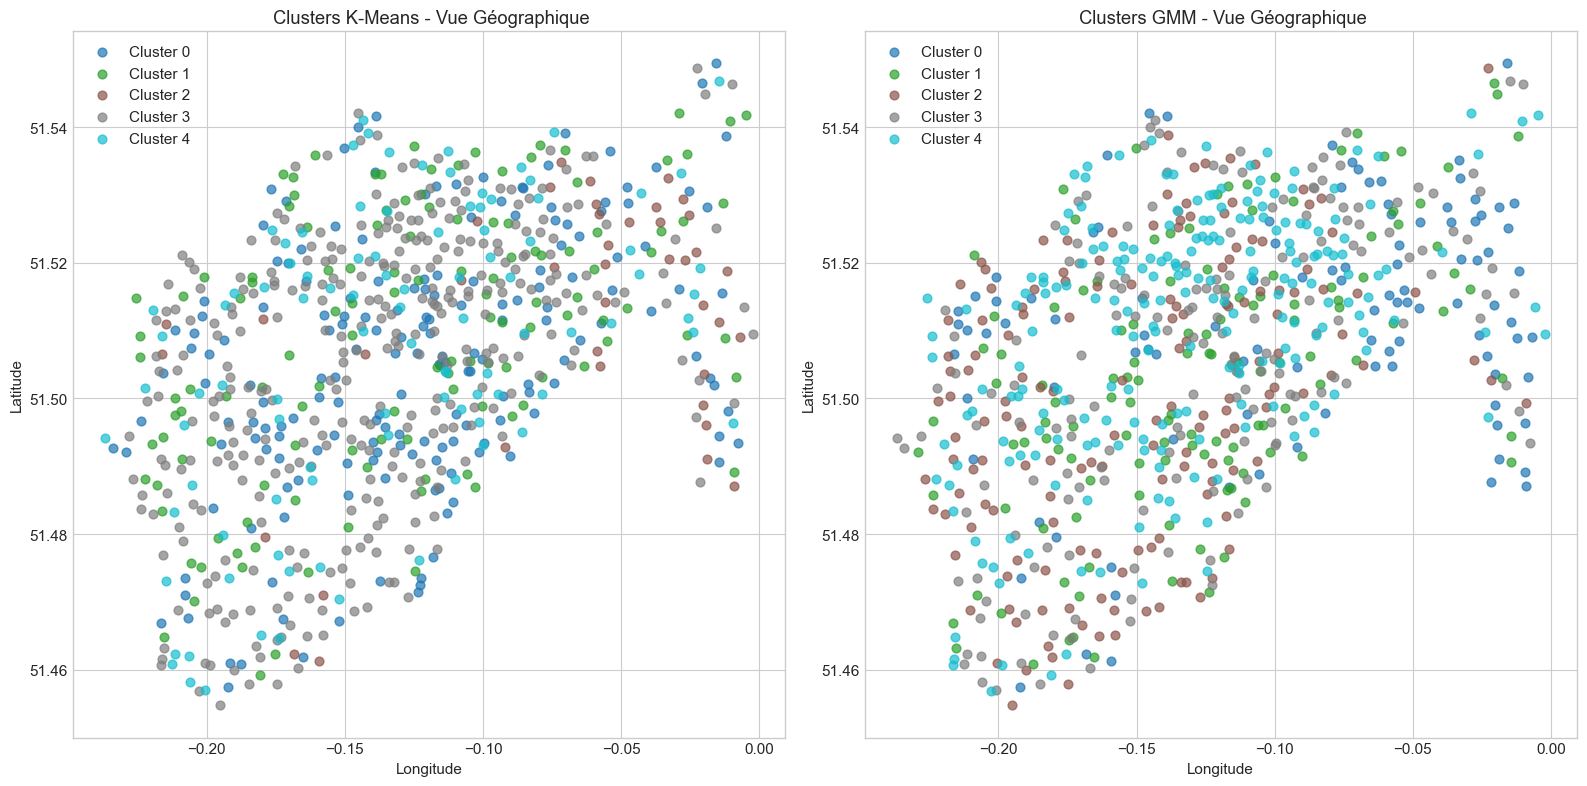

In [42]:
# Visualisation géographique des clusters
# On doit faire correspondre les stations avec leurs coordonnées
n_stations = min(len(stations), len(labels_gmm))

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# K-means sur la carte
for i in range(K):
    mask = labels_kmeans[:n_stations] == i
    axes[0].scatter(stations['Longitude'].iloc[:n_stations][mask], 
                   stations['Latitude'].iloc[:n_stations][mask],
                   c=[colors[i]], label=f'Cluster {i}', s=40, alpha=0.7)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title(' Clusters K-Means - Vue Géographique')
axes[0].legend()

# GMM sur la carte
for i in range(K):
    mask = labels_gmm[:n_stations] == i
    axes[1].scatter(stations['Longitude'].iloc[:n_stations][mask], 
                   stations['Latitude'].iloc[:n_stations][mask],
                   c=[colors[i]], label=f'Cluster {i}', s=40, alpha=0.7)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title(' Clusters GMM - Vue Géographique')
axes[1].legend()

plt.tight_layout()
plt.savefig('../results/clusters_geo.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Modélisation Probabiliste

In [43]:
# Calcul des distances dans l'espace latent
# d_ij = ||Z_i - Z_j||_2

distances_latentes = cdist(mu_z, mu_z, metric='euclidean')

print("=== DISTANCES LATENTES ===")
print(f"Shape: {distances_latentes.shape}")
print(f"Distance min (hors diag): {distances_latentes[distances_latentes > 0].min():.4f}")
print(f"Distance max: {distances_latentes.max():.4f}")
print(f"Distance moyenne: {distances_latentes.mean():.4f}")

=== DISTANCES LATENTES ===
Shape: (779, 779)
Distance min (hors diag): 1.2724
Distance max: 232.9117
Distance moyenne: 37.9375


In [44]:
# Modèle: P(A_ij = 1 | Z_i, Z_j) = sigmoid(-alpha * d_ij + beta)

def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

# Estimation des paramètres alpha et beta par régression logistique
from sklearn.linear_model import LogisticRegression

# Préparation des données pour la régression
# On prend un échantillon pour accélérer le calcul
n = A_binaire.shape[0]
idx_upper = np.triu_indices(n, k=1)  # Indices triangulaire supérieur

y = A_binaire[idx_upper]  # Variable cible (connexion ou non)
X = distances_latentes[idx_upper].reshape(-1, 1)  # Distance latente

# Échantillonnage (le dataset complet est trop grand)
sample_size = min(100000, len(y))
np.random.seed(42)
sample_idx = np.random.choice(len(y), sample_size, replace=False)

X_sample = X[sample_idx]
y_sample = y[sample_idx]

# Régression logistique
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_sample, y_sample)

alpha = -log_reg.coef_[0][0]  # Le coefficient de la distance
beta = log_reg.intercept_[0]

print("=== MODÈLE PROBABILISTE ===")
print(f"P(A_ij = 1 | Z_i, Z_j) = σ(-α·d_ij + β)")
print(f"\nParamètres estimés:")
print(f"  α (alpha) = {alpha:.4f}")
print(f"  β (beta) = {beta:.4f}")
print(f"\nAccuracy sur l'échantillon: {log_reg.score(X_sample, y_sample):.4f}")

=== MODÈLE PROBABILISTE ===
P(A_ij = 1 | Z_i, Z_j) = σ(-α·d_ij + β)

Paramètres estimés:
  α (alpha) = 0.0148
  β (beta) = 0.0259

Accuracy sur l'échantillon: 0.6253


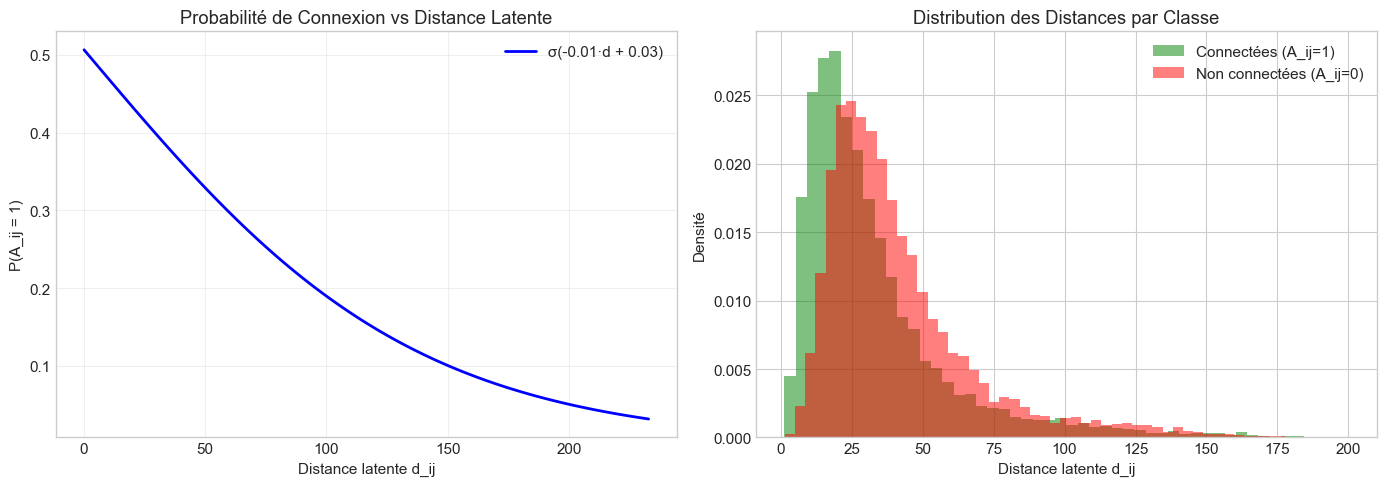

In [45]:
# Visualisation du modèle probabiliste
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Probabilité en fonction de la distance
d_range = np.linspace(0, distances_latentes.max(), 100)
p_range = sigmoid(-alpha * d_range + beta)

axes[0].plot(d_range, p_range, 'b-', linewidth=2, label=f'σ(-{alpha:.2f}·d + {beta:.2f})')
axes[0].set_xlabel('Distance latente d_ij')
axes[0].set_ylabel('P(A_ij = 1)')
axes[0].set_title('Probabilité de Connexion vs Distance Latente')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distribution des distances par classe
d_connectes = X[y == 1].flatten()
d_non_connectes = X[y == 0].flatten()

# Échantillonnage pour visualisation
sample_conn = np.random.choice(d_connectes, min(10000, len(d_connectes)), replace=False)
sample_non = np.random.choice(d_non_connectes, min(10000, len(d_non_connectes)), replace=False)

axes[1].hist(sample_conn, bins=50, alpha=0.5, density=True, label='Connectées (A_ij=1)', color='green')
axes[1].hist(sample_non, bins=50, alpha=0.5, density=True, label='Non connectées (A_ij=0)', color='red')
axes[1].set_xlabel('Distance latente d_ij')
axes[1].set_ylabel('Densité')
axes[1].set_title('Distribution des Distances par Classe')
axes[1].legend()

plt.tight_layout()
plt.savefig('../results/modele_probabiliste.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Analyse du Réseau avec NetworkX

In [46]:
# Création du graphe NetworkX
G = nx.from_numpy_array(A_binaire)

print("=== PROPRIÉTÉS DU GRAPHE ===")
print(f"Nombre de nœuds: {G.number_of_nodes()}")
print(f"Nombre d'arêtes: {G.number_of_edges()}")
print(f"Densité: {nx.density(G):.4f}")

# Composantes connexes
n_composantes = nx.number_connected_components(G)
print(f"\nNombre de composantes connexes: {n_composantes}")

if n_composantes == 1:
    print(f"Diamètre du graphe: {nx.diameter(G)}")
    print(f"Rayon du graphe: {nx.radius(G)}")

=== PROPRIÉTÉS DU GRAPHE ===
Nombre de nœuds: 779
Nombre d'arêtes: 141377
Densité: 0.4665

Nombre de composantes connexes: 1
Diamètre du graphe: 3
Rayon du graphe: 2


In [47]:
# Métriques de centralité
degree_centrality = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G, k=min(500, len(G)))  # Approximation
closeness = nx.closeness_centrality(G)

# Conversion en arrays
dc = np.array(list(degree_centrality.values()))
bc = np.array(list(betweenness.values()))
cc = np.array(list(closeness.values()))

print("=== CENTRALITÉS ===")
print(f"\nDegree Centrality: min={dc.min():.4f}, max={dc.max():.4f}, mean={dc.mean():.4f}")
print(f"Betweenness Centrality: min={bc.min():.6f}, max={bc.max():.6f}, mean={bc.mean():.6f}")
print(f"Closeness Centrality: min={cc.min():.4f}, max={cc.max():.4f}, mean={cc.mean():.4f}")

=== CENTRALITÉS ===

Degree Centrality: min=0.1080, max=0.8483, mean=0.4665
Betweenness Centrality: min=0.000014, max=0.003799, mean=0.000692
Closeness Centrality: min=0.5246, max=0.8683, mean=0.6587


In [25]:
# Top 10 stations les plus centrales
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]

print("=== TOP 10 STATIONS - DEGREE CENTRALITY ===")
for idx, (node, cent) in enumerate(top_degree):
    if node < len(stations):
        name = stations.iloc[node]['Station Name']
        print(f"{idx+1}. Station {node}: {name[:40]} (centrality={cent:.4f})")

print("\n=== TOP 10 STATIONS - BETWEENNESS CENTRALITY ===")
for idx, (node, cent) in enumerate(top_betweenness):
    if node < len(stations):
        name = stations.iloc[node]['Station Name']
        print(f"{idx+1}. Station {node}: {name[:40]} (centrality={cent:.6f})")

=== TOP 10 STATIONS - DEGREE CENTRALITY ===
1. Station 62: Holborn Circus, Holborn (centrality=0.8483)
2. Station 327: Howland Street, Fitzrovia (centrality=0.8432)
3. Station 160: Porchester Place, Paddington (centrality=0.8406)
4. Station 280: Rathbone Street, Fitzrovia (centrality=0.8329)
5. Station 216: Dock Street, Wapping (centrality=0.8265)
6. Station 98: Westbourne Grove, Bayswater (centrality=0.8213)
7. Station 100: Finsbury Leisure Centre, St. Luke's (centrality=0.8213)
8. Station 118: Borough High Street, The Borough (centrality=0.8213)
9. Station 57: Great Dover Street, The Borough (centrality=0.8149)
10. Station 361: Aberdeen Place, St. John's Wood (centrality=0.8136)

=== TOP 10 STATIONS - BETWEENNESS CENTRALITY ===
1. Station 216: Dock Street, Wapping (centrality=0.003603)
2. Station 57: Great Dover Street, The Borough (centrality=0.003531)
3. Station 280: Rathbone Street, Fitzrovia (centrality=0.003445)
4. Station 62: Holborn Circus, Holborn (centrality=0.003385)
5. Sta

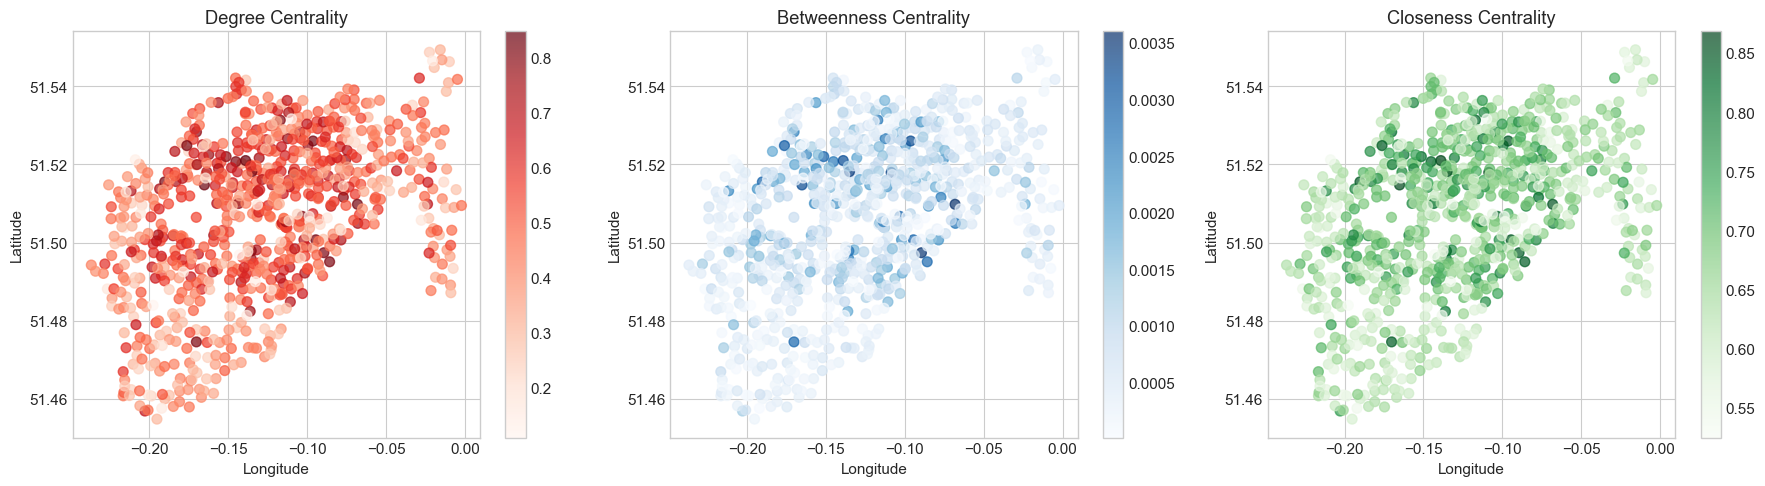

In [26]:
# Visualisation des centralités
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Degree centrality sur la carte
scatter1 = axes[0].scatter(
    stations['Longitude'].iloc[:len(dc)], 
    stations['Latitude'].iloc[:len(dc)],
    c=dc[:len(stations)], cmap='Reds', s=50, alpha=0.7
)
axes[0].set_title('Degree Centrality')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
plt.colorbar(scatter1, ax=axes[0])

# Betweenness centrality sur la carte
scatter2 = axes[1].scatter(
    stations['Longitude'].iloc[:len(bc)], 
    stations['Latitude'].iloc[:len(bc)],
    c=bc[:len(stations)], cmap='Blues', s=50, alpha=0.7
)
axes[1].set_title('Betweenness Centrality')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
plt.colorbar(scatter2, ax=axes[1])

# Closeness centrality sur la carte
scatter3 = axes[2].scatter(
    stations['Longitude'].iloc[:len(cc)], 
    stations['Latitude'].iloc[:len(cc)],
    c=cc[:len(stations)], cmap='Greens', s=50, alpha=0.7
)
axes[2].set_title('Closeness Centrality')
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')
plt.colorbar(scatter3, ax=axes[2])

plt.tight_layout()
plt.savefig('../results/centralites_geo.png', dpi=150, bbox_inches='tight')
plt.show()

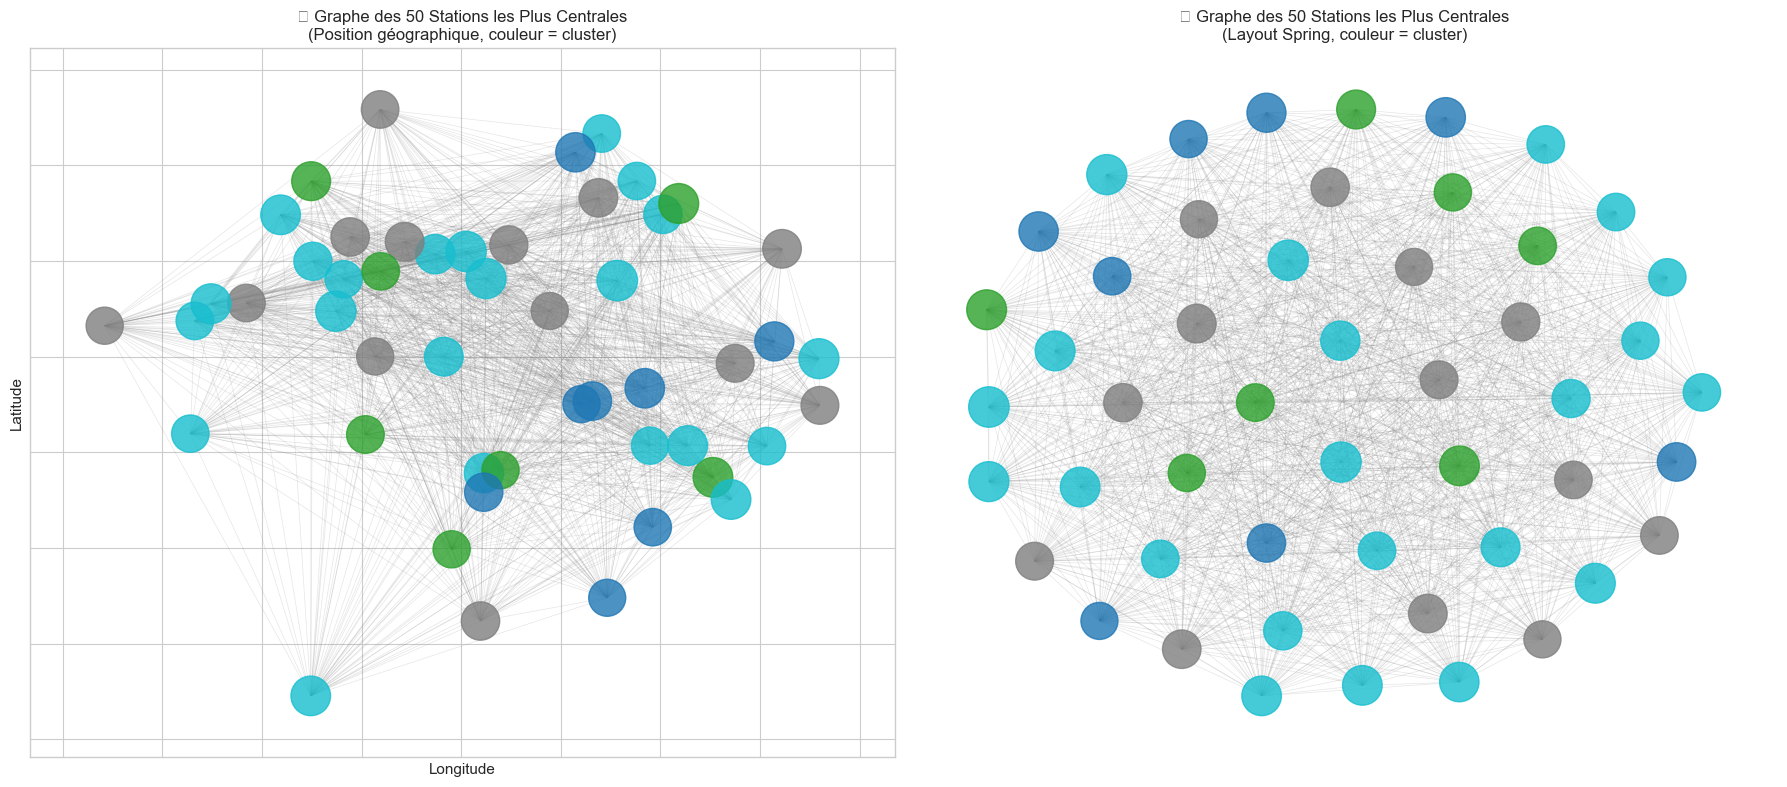

✅ Visualisation du graphe avec les 50 stations les plus centrales
   Nœuds: 50, Arêtes: 1223


In [48]:
# Visualisation du graphe - Top 50 stations les plus centrales
top_n = 50
top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:top_n]
top_node_ids = [n[0] for n in top_nodes]

# Créer un sous-graphe avec les stations les plus centrales
G_sub = G.subgraph(top_node_ids).copy()

# Positions basées sur les coordonnées géographiques
pos = {}
for node in G_sub.nodes():
    if node < len(stations):
        pos[node] = (stations.iloc[node]['Longitude'], stations.iloc[node]['Latitude'])
    else:
        pos[node] = (0, 0)

# Tailles des nœuds basées sur le degré
node_sizes = [degree_centrality[n] * 1000 for n in G_sub.nodes()]

# Couleurs basées sur les clusters
node_colors = [labels_kmeans[n] if n < len(labels_kmeans) else 0 for n in G_sub.nodes()]

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Visualisation avec layout géographique
nx.draw_networkx_nodes(G_sub, pos, ax=axes[0], node_size=node_sizes, 
                       node_color=node_colors, cmap='tab10', alpha=0.8)
nx.draw_networkx_edges(G_sub, pos, ax=axes[0], alpha=0.2, edge_color='gray', width=0.5)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title(f'🔗 Graphe des {top_n} Stations les Plus Centrales\n(Position géographique, couleur = cluster)', fontsize=12)

# Visualisation avec layout spring
pos_spring = nx.spring_layout(G_sub, seed=42, k=2)
nx.draw_networkx_nodes(G_sub, pos_spring, ax=axes[1], node_size=node_sizes, 
                       node_color=node_colors, cmap='tab10', alpha=0.8)
nx.draw_networkx_edges(G_sub, pos_spring, ax=axes[1], alpha=0.2, edge_color='gray', width=0.5)
axes[1].set_title(f'🔗 Graphe des {top_n} Stations les Plus Centrales\n(Layout Spring, couleur = cluster)', fontsize=12)
axes[1].axis('off')

plt.tight_layout()
plt.savefig('../results/graphe_top_stations.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Visualisation du graphe avec les {top_n} stations les plus centrales")
print(f"   Nœuds: {G_sub.number_of_nodes()}, Arêtes: {G_sub.number_of_edges()}")

In [ ]:
# Visualisation du graphe complet avec échantillonnage par cluster
# On prend quelques stations représentatives de chaque cluster

fig, ax = plt.subplots(figsize=(14, 12))

# Sélectionner 30 stations par cluster (les plus centrales de chaque cluster)
selected_nodes = []
for k in range(K):
    cluster_nodes = [n for n in range(len(labels_kmeans)) if labels_kmeans[n] == k]
    # Trier par centralité
    cluster_nodes_sorted = sorted(cluster_nodes, key=lambda x: degree_centrality.get(x, 0), reverse=True)
    selected_nodes.extend(cluster_nodes_sorted[:30])

# Créer le sous-graphe
G_cluster = G.subgraph(selected_nodes).copy()

# Positions géographiques
pos_geo = {}
for node in G_cluster.nodes():
    if node < len(stations):
        pos_geo[node] = (stations.iloc[node]['Longitude'], stations.iloc[node]['Latitude'])

# Couleurs par cluster
node_colors_cluster = [labels_kmeans[n] for n in G_cluster.nodes() if n < len(labels_kmeans)]
node_sizes_cluster = [degree_centrality.get(n, 0.1) * 800 + 50 for n in G_cluster.nodes()]

# Dessiner les arêtes avec transparence
edges = G_cluster.edges()
edge_colors = []
for u, v in edges:
    if labels_kmeans[u] == labels_kmeans[v]:
        edge_colors.append('darkgray')  # Intra-cluster
    else:
        edge_colors.append('lightgray')  # Inter-cluster

nx.draw_networkx_edges(G_cluster, pos_geo, ax=ax, alpha=0.3, 
                       edge_color=edge_colors, width=0.3)

# Dessiner les nœuds
scatter = nx.draw_networkx_nodes(G_cluster, pos_geo, ax=ax, 
                                 node_size=node_sizes_cluster,
                                 node_color=node_colors_cluster, 
                                 cmap='tab10', alpha=0.85,
                                 edgecolors='white', linewidths=0.5)

# Légende
for k in range(K):
    ax.scatter([], [], c=[plt.cm.tab10(k)], s=100, label=f'Cluster {k}')
ax.legend(title='Clusters', loc='upper left', fontsize=10)

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('🗺️ Réseau de Vélos de Londres - Structure par Clusters\n(150 stations représentatives, taille = centralité)', fontsize=14)

plt.tight_layout()
plt.savefig('../results/graphe_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Graphe avec structure de clusters")
print(f"   {G_cluster.number_of_nodes()} nœuds, {G_cluster.number_of_edges()} arêtes")

## 8. Analyse par Cluster

In [28]:
# Statistiques par cluster
cluster_stats = []

for k in range(K):
    mask = labels_gmm[:n_stations] == k
    stations_cluster = stations.iloc[:n_stations][mask]
    
    stats = {
        'Cluster': k,
        'Nb Stations': mask.sum(),
        'Capacité Moyenne': stations_cluster['Capacity'].mean(),
        'Lat Moyenne': stations_cluster['Latitude'].mean(),
        'Long Moyenne': stations_cluster['Longitude'].mean(),
        'Degré Moyen': degres[:n_stations][mask].mean(),
    }
    cluster_stats.append(stats)

df_stats = pd.DataFrame(cluster_stats)
print("=== STATISTIQUES PAR CLUSTER ===")
display(df_stats.round(2))

=== STATISTIQUES PAR CLUSTER ===


Cluster  Nb Stations  Capacité Moyenne  Lat Moyenne  Long Moyenne  \
0        0          102             27.97        51.51         -0.09   
1        1          128             26.16        51.50         -0.13   
2        2          156             26.38        51.50         -0.15   
3        3          172             27.07        51.51         -0.13   
4        4          215             26.45        51.51         -0.13   

   Degré Moyen  
0       214.77  
1       271.74  
2       259.43  
3       295.17  
4       351.25

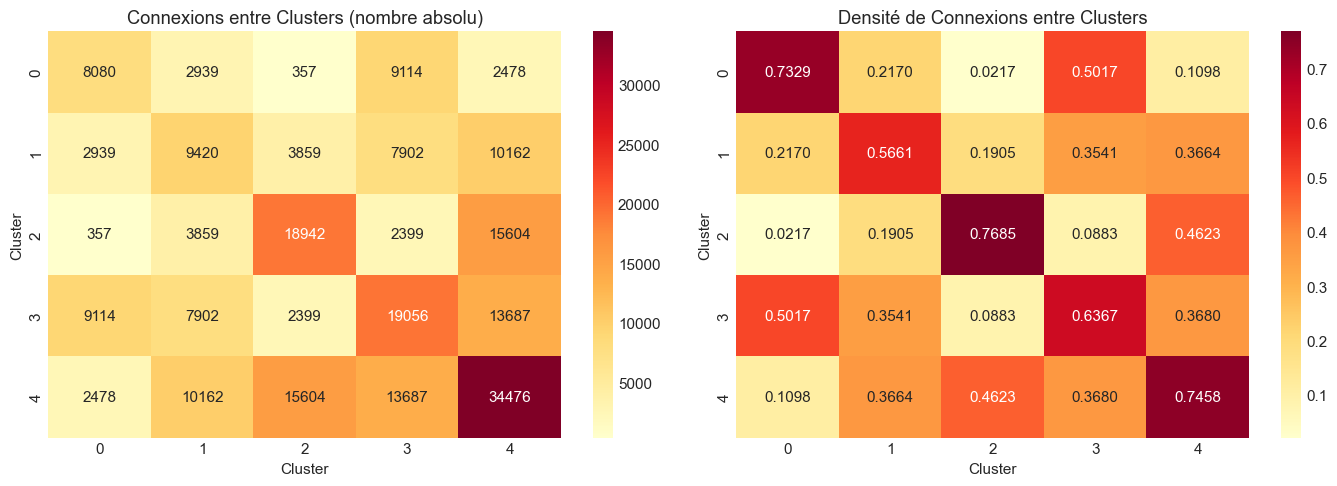

In [29]:
# Matrice de confusion des connexions entre clusters
cluster_connectivity = np.zeros((K, K))

for i in range(len(labels_gmm)):
    for j in range(i+1, len(labels_gmm)):
        if A_binaire[i, j] == 1:
            ci, cj = labels_gmm[i], labels_gmm[j]
            cluster_connectivity[ci, cj] += 1
            cluster_connectivity[cj, ci] += 1

# Normalisation
cluster_counts = np.bincount(labels_gmm, minlength=K)
cluster_connectivity_norm = cluster_connectivity / (cluster_counts[:, None] * cluster_counts[None, :])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matrice brute
sns.heatmap(cluster_connectivity, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[0])
axes[0].set_title('Connexions entre Clusters (nombre absolu)')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Cluster')

# Matrice normalisée
sns.heatmap(cluster_connectivity_norm, annot=True, fmt='.4f', cmap='YlOrRd', ax=axes[1])
axes[1].set_title('Densité de Connexions entre Clusters')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Cluster')

plt.tight_layout()
plt.savefig('../results/connexions_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Résumé et Conclusions

In [ ]:
print("="*60)
print("       RÉSUMÉ DE L'ANALYSE DU RÉSEAU DE VÉLOS DE LONDRES")
print("="*60)

print(f"""
 DONNÉES
   - {stations.shape[0]} stations de vélos
   - {journeys.shape[0]:,} trajets analysés
   - Matrice de connectivité: {A.shape[0]} x {A.shape[1]}

 RÉSEAU
   - {G.number_of_edges():,} connexions (paires de stations avec au moins un trajet)
   - Densité du graphe: {nx.density(G):.4f}
   - Degré moyen: {degres.mean():.1f} connexions par station

RÉDUCTION DE DIMENSION
   - Méthode: ACP Probabiliste (PPCA)
   - Dimension latente: {mu_z.shape[1]}
   - Variance expliquée (17 composantes): {pca_d.explained_variance_ratio_.sum():.2%}

CLUSTERING
   - Nombre de clusters: {K}
   - Score silhouette (K-means): {silhouette_score(mu_z, labels_kmeans):.4f}
   - Score silhouette (GMM): {silhouette_score(mu_z, labels_gmm):.4f}
   - Accord K-means/GMM (ARI): {adjusted_rand_score(labels_kmeans, labels_gmm):.4f}

📈 MODÈLE PROBABILISTE
   - P(A_ij = 1 | Z_i, Z_j) = σ(-α·d_ij + β)
   - α = {alpha:.4f}
   - β = {beta:.4f}
   - Plus les stations sont proches dans l'espace latent, plus elles ont
     de chances d'être connectées.
""")

print("="*60)
print("       FICHIERS GÉNÉRÉS DANS results/")
print("="*60)
print("""
   📁 carte_stations.png         - Carte géographique des stations
   📁 matrices_connectivite.png  - Visualisation des matrices A
   📁 distribution_degres_poids.png - Distributions statistiques
   📁 acp_variance.png           - Analyse de variance ACP
   📁 espace_latent_2d.png       - Projection 2D de l'espace latent
   📁 selection_k.png            - Sélection du nombre de clusters
   📁 clusters_2d.png            - Clusters dans l'espace latent
   📁 clusters_geo.png           - Clusters sur la carte
   📁 modele_probabiliste.png    - Courbe du modèle probabiliste
   📁 centralites_geo.png        - Mesures de centralité
   📁 connexions_clusters.png    - Matrice de connexions inter-clusters
""")

       RÉSUMÉ DE L'ANALYSE DU RÉSEAU DE VÉLOS DE LONDRES

📊 DONNÉES
   - 773 stations de vélos
   - 1,542,844 trajets analysés
   - Matrice de connectivité: 779 x 779

🔗 RÉSEAU
   - 141,377 connexions (paires de stations avec au moins un trajet)
   - Densité du graphe: 0.4665
   - Degré moyen: 287.6 connexions par station

📉 RÉDUCTION DE DIMENSION
   - Méthode: ACP Probabiliste (PPCA)
   - Dimension latente: 17
   - Variance expliquée (17 composantes): 52.48%

🎯 CLUSTERING
   - Nombre de clusters: 5
   - Score silhouette (K-means): 0.3312
   - Score silhouette (GMM): 0.0553
   - Accord K-means/GMM (ARI): 0.2634

📈 MODÈLE PROBABILISTE
   - P(A_ij = 1 | Z_i, Z_j) = σ(-α·d_ij + β)
   - α = 0.0148
   - β = 0.0259
   - Plus les stations sont proches dans l'espace latent, plus elles ont
     de chances d'être connectées.

       FICHIERS GÉNÉRÉS DANS results/

   📁 carte_stations.png         - Carte géographique des stations
   📁 matrices_connectivite.png  - Visualisation des matrices A
   📁

In [31]:
# Sauvegarde des résultats
results = {
    'labels_kmeans': labels_kmeans,
    'labels_gmm': labels_gmm,
    'proba_gmm': proba_gmm,
    'distances_latentes': distances_latentes,
    'alpha': alpha,
    'beta': beta,
    'centrality_degree': dc,
    'centrality_betweenness': bc,
    'centrality_closeness': cc
}

np.savez('../results/resultats_analyse.npz', **results)
print("✅ Résultats sauvegardés dans results/resultats_analyse.npz")

✅ Résultats sauvegardés dans results/resultats_analyse.npz
